In [0]:
%connect

Testing ssh> ssh -oStrictHostKeyChecking=no -p 22 shichiroji true
attempting to create tunnels from ipc@shichiroji to ipc@shichiroji
starting ssh tunnel> ssh -oStrictHostKeyChecking=no -S none -nT -L /home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc-shichiroji:/home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc -p 22 shichiroji sleep 30
waiting for local ipc socket - 5
connected to shichiroji
to disconnect: %disconnect


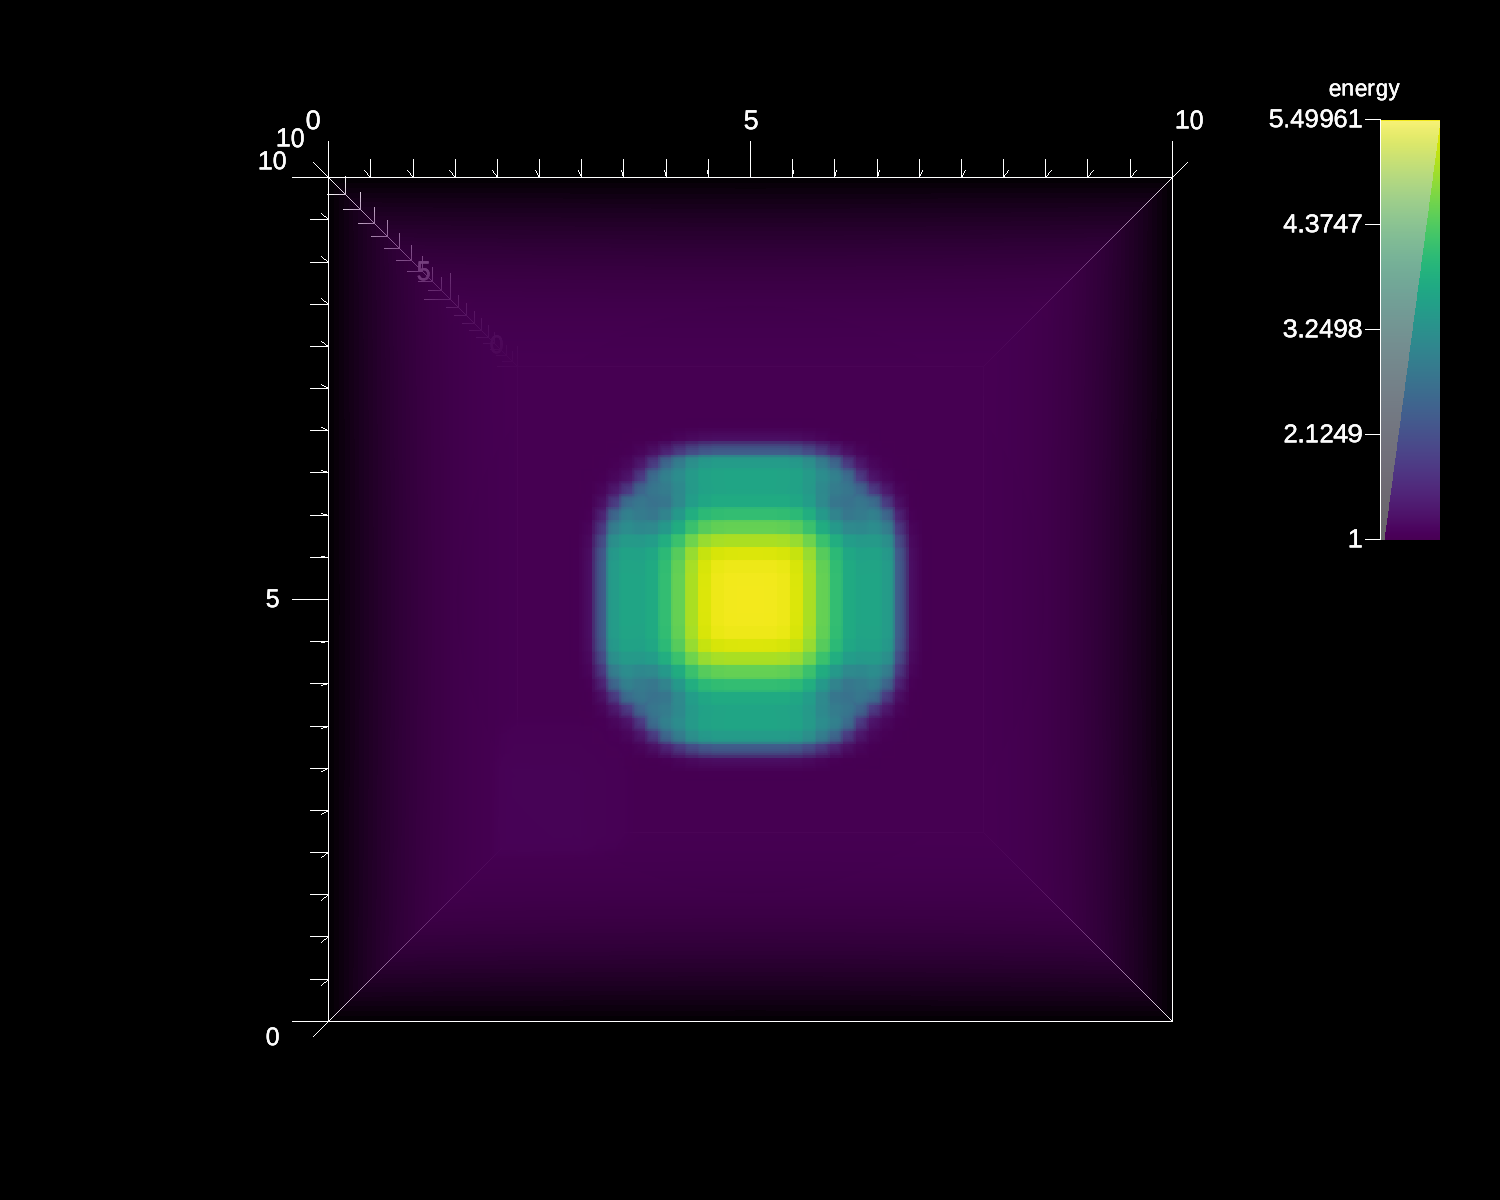

In [1]:
import ascent.mpi
comm = MPI.Comm.f2py(ascent_mpi_comm_id())
a = ascent.mpi.Ascent()
ascent_opts = conduit.Node()
ascent_opts["mpi_comm"].set(comm.py2f())
ascent_opts["actions_file"] = ""
a.open(ascent_opts)
a.publish(ascent_data())
yaml = """

- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "volume"
          field: "energy"
      renders:
        r1:
          image_width: "1500"
          image_height: "1200"
- 
  action: "execute"
- 
  action: "reset"

"""
generated = conduit.Generator(yaml, "yaml")
actions = conduit.Node()
generated.walk(actions)
a.execute(actions)
info = conduit.Node()
a.info(info)
for img in info["images"].children():
    with open(img.node()["image_name"], 'rb') as f:
        img_content = f.read()
        image(img_content, "png")

In [43]:
%disconnect

In [ ]:
'''
info = conduit.Node()
a.info(info)
image_filename = info["images"][0]["image_name"]
from IPython.display import display, Image
with open(image_filename, 'rb') as f:
    image_content = f.read()
    image(image_content, "png")
'''

In [237]:
%exec_local
import ipywidgets as widgets
from IPython.display import display as ipydisplay, clear_output

import contextlib

import copy

code = '''
import ascent.mpi
comm = MPI.Comm.f2py(ascent_mpi_comm_id())
a = ascent.mpi.Ascent()
ascent_opts = conduit.Node()
ascent_opts["mpi_comm"].set(comm.py2f())
ascent_opts["actions_file"] = ""
a.open(ascent_opts)
a.publish(ascent_data())
yaml = """

- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "volume"
          field: "energy"
      renders:
        r1:
          image_width: "700"
          image_height: "900"
- 
  action: "execute"
- 
  action: "reset"

"""
generated = conduit.Generator(yaml, "yaml")
actions = conduit.Node()
generated.walk(actions)
a.execute(actions)
info = conduit.Node()
a.info(info)
for img in info["images"].children():
    with open(img.node()["image_name"], 'rb') as f:
        img_content = f.read()
        image(img_content, "png")
'''

def handle_next(button):
    with contextlib.redirect_stdout(None):
        kernel.connect_wait(copy.deepcopy(kernel.last_used_backend))
    clear_output(wait=True)
    kernel.do_execute(code, silent=True)
    widgs = []
    widgs.append(button)
    ipydisplay(widgets.VBox(widgs))
    

button = widgets.Button(description="Next Step")
button.on_click(handle_next)
widgs = []
widgs.append(button)
ipydisplay(widgets.VBox(widgs))

In [173]:
%exec_local
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display as ipydisplay, clear_output

import json

code = '''
import numpy

#return a vector pointing in the same direction as vec with length 1
def normalize(vec):
    return vec / numpy.sqrt((vec**2).sum())
    
#rotates p0 by radians around the axis formed by p1 and p2
#source: http://paulbourke.net/geometry/rotate/
def rotate(p0, p1, p2, radians):
    #unit normalized vector formed by p2 - p1
    normalized_position = normalize(p2 - p1)
    a = normalized_position[0]
    b = normalized_position[1]
    c = normalized_position[2]

    #length of projection of normalized_position on the xy plane
    d = numpy.sqrt(b**2 + c**2)
    
    #translate rotation axis to origin
    translate = numpy.array([
        [1, 0, 0, -p1[0]],
        [0, 1, 0, -p1[1]],
        [0, 0, 1, -p1[2]],
        [0, 0, 0,      1]
    ])
    translate_inv = numpy.array([
        [1, 0, 0, p1[0]],
        [0, 1, 0, p1[1]],
        [0, 0, 1, p1[2]],
        [0, 0, 0,     1]
    ])
    #rotate about x axis so the rotation axis lies in the xz plane
    rot_x = numpy.array([
        [1,   0,    0, 0],
        [0, c/d, -b/d, 0],
        [0, b/d,  c/d, 0],
        [0,   0,    0, 1]
    ])
    rot_x_inv = numpy.array([
        [1,    0,   0, 0],
        [0,  c/d, b/d, 0],
        [0, -b/d, c/d, 0],
        [0,    0,   0, 1]
    ])
    #rotate about y axis so the roation axis lies on the z axis
    rot_y = numpy.array([
        [d, 0, -a, 0],
        [0, 1,  0, 0],
        [a, 0,  d, 0],
        [0, 0,  0, 1]
    ])
    rot_y_inv = numpy.array([
        [ d, 0, a, 0],
        [ 0, 1, 0, 0],
        [-a, 0, d, 0],
        [ 0, 0, 0, 1]
    ])
    #rotate about z axis
    rot_z = numpy.array([
        [numpy.cos(radians), -numpy.sin(radians), 0, 0],
        [numpy.sin(radians), numpy.cos(radians), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    #multiply by all the forward transforms followed by reverse transforms
    return translate_inv @ rot_x_inv @ rot_y_inv @ rot_z @ rot_y @ rot_x @ translate @ p0

def move_up(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )

    render_info['camera']['position'] = numpy.add(position, numpy.array(up) * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, numpy.array(up) * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']
    
def move_forward(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))

    render_info['camera']['position'] = numpy.add(position, forward * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, forward * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def move_right(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    render_info['camera']['position'] = numpy.add(position, right * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, right * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

#rotate the camera about the direction we are looking in 
def roll(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #point for up relative to position 4-vector ready for transformation
    pup = numpy.append(up + position, 1)

    #rotated up vector
    res_up = rotate(pup, position, look_at, radians)[:-1] - position

    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def pitch(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated look_at point
    res_look_at = rotate(plook_at, position, position + right, radians)[:-1]
    res_up = normalize(numpy.cross(right, res_look_at - position))

    render_info['camera']['look_at'] = res_look_at
    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']


def yaw(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated up vector
    res_look_at = rotate(plook_at, position, position + up, radians)[:-1]

    render_info['camera']['look_at'] = res_look_at

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def display_images(info):
    for img in info["images"].children():
        with open(img.node()["image_name"], 'rb') as f:
            img_content = f.read()
            image(img_content, "png")

info = conduit.Node()
a.info(info)
a.execute({}(info, {}))
a.info(info)
#print(info)
display_images(info)
'''

def display_buttons():
    pan_buttons = VBox(children=[
                button_up,
                HBox(children=[
                button_left,
                button_down,
                button_right
            ])
        ],
        layout=Layout(align_items='center')
    ) 

    
    forward_back_buttons = HBox(children=[button_forward, button_back])
    roll_buttons = HBox(children=[button_roll_c, button_roll_cc])
    pitch_buttons = HBox(children=[button_pitch_up, button_pitch_down])
    yaw_buttons = HBox(children=[button_yaw_right, button_yaw_left])
    
    other_buttons = VBox(children=[
        forward_back_buttons,
        roll_buttons,
        pitch_buttons,
        yaw_buttons
    ])
    
    
    ipydisplay(pan_buttons)
    ipydisplay(other_buttons)

    
def handle_up(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_up', 0.1), silent=True)
    display_buttons()

def handle_down(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_up', -0.1), silent=True)
    display_buttons()

def handle_forward(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_forward', 0.1), silent=True)
    display_buttons()

def handle_back(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_forward', -0.1), silent=True)
    display_buttons()

def handle_right(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_right', 0.1), silent=True)
    display_buttons()
    
def handle_left(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('move_right', -0.1), silent=True)
    display_buttons()
    
def handle_roll_c(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('roll', '-2*numpy.pi/36'), silent=True)
    display_buttons()
    
def handle_roll_cc(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('roll', '2*numpy.pi/36'), silent=True)
    display_buttons()
    
def handle_pitch_up(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('pitch', '2*numpy.pi/36'), silent=True)
    display_buttons()
    
def handle_pitch_down(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('pitch', '-2*numpy.pi/36'), silent=True)
    display_buttons()
    
def handle_yaw_right(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('yaw', '-2*numpy.pi/36'), silent=True)
    display_buttons()
    
def handle_yaw_left(button):
    clear_output(wait=True)
    kernel.do_execute(code.format('yaw', '2*numpy.pi/36'), silent=True)
    display_buttons()
    

button_up = widgets.Button(description="Move up")
button_up.on_click(handle_up)

button_down = widgets.Button(description="Move down")
button_down.on_click(handle_down)

button_forward = widgets.Button(description="Move forward")
button_forward.on_click(handle_forward)

button_back = widgets.Button(description="Move back")
button_back.on_click(handle_back)

button_right = widgets.Button(description="Move right")
button_right.on_click(handle_right)

button_left = widgets.Button(description="Move left")
button_left.on_click(handle_left)

button_roll_cc = widgets.Button(description="Roll counterclockwise")
button_roll_cc.on_click(handle_roll_cc)

button_roll_c = widgets.Button(description="Roll clockwise")
button_roll_c.on_click(handle_roll_c)

button_pitch_up = widgets.Button(description="Pitch up")
button_pitch_up.on_click(handle_pitch_up)

button_pitch_down = widgets.Button(description="Pitch down")
button_pitch_down.on_click(handle_pitch_down)

button_yaw_right = widgets.Button(description="Yaw right")
button_yaw_right.on_click(handle_yaw_right)

button_yaw_left = widgets.Button(description="Yaw left")
button_yaw_left.on_click(handle_yaw_left)

display_buttons()

In [1]:
%exec_local

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display as ipydisplay, clear_output
from traitlets import Unicode, validate, Int, List, Dict
from IPython.display import Javascript
import json
import copy

server_code = '''
import numpy

#return a vector pointing in the same direction as vec with length 1
def normalize(vec):
    return vec / numpy.sqrt((vec**2).sum())
    
#rotates p0 by radians around the axis formed by p1 and p2
#source: http://paulbourke.net/geometry/rotate/
def rotate(p0, p1, p2, radians):
    #unit normalized vector formed by p2 - p1
    normalized_position = normalize(p2 - p1)
    a = normalized_position[0]
    b = normalized_position[1]
    c = normalized_position[2]

    #length of projection of normalized_position on the xy plane
    d = numpy.sqrt(b**2 + c**2)
    
    #translate rotation axis to origin
    translate = numpy.array([
        [1, 0, 0, -p1[0]],
        [0, 1, 0, -p1[1]],
        [0, 0, 1, -p1[2]],
        [0, 0, 0,      1]
    ])
    translate_inv = numpy.array([
        [1, 0, 0, p1[0]],
        [0, 1, 0, p1[1]],
        [0, 0, 1, p1[2]],
        [0, 0, 0,     1]
    ])
    #rotate about x axis so the rotation axis lies in the xz plane
    rot_x = numpy.array([
        [1,   0,    0, 0],
        [0, c/d, -b/d, 0],
        [0, b/d,  c/d, 0],
        [0,   0,    0, 1]
    ])
    rot_x_inv = numpy.array([
        [1,    0,   0, 0],
        [0,  c/d, b/d, 0],
        [0, -b/d, c/d, 0],
        [0,    0,   0, 1]
    ])
    #rotate about y axis so the roation axis lies on the z axis
    rot_y = numpy.array([
        [d, 0, -a, 0],
        [0, 1,  0, 0],
        [a, 0,  d, 0],
        [0, 0,  0, 1]
    ])
    rot_y_inv = numpy.array([
        [ d, 0, a, 0],
        [ 0, 1, 0, 0],
        [-a, 0, d, 0],
        [ 0, 0, 0, 1]
    ])
    #rotate about z axis
    rot_z = numpy.array([
        [numpy.cos(radians), -numpy.sin(radians), 0, 0],
        [numpy.sin(radians), numpy.cos(radians), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    #multiply by all the forward transforms followed by reverse transforms
    return translate_inv @ rot_x_inv @ rot_y_inv @ rot_z @ rot_y @ rot_x @ translate @ p0



def look_at(info, position, look_at, up):
    render_info = info['images'][0]

    #TODO figure out why it needs a numpy array
    render_info['camera']['position'] = numpy.array(position)
    render_info['camera']['look_at'] = numpy.array(look_at)
    render_info['camera']['up'] = numpy.array(up)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']


def move_up(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )

    render_info['camera']['position'] = numpy.add(position, numpy.array(up) * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, numpy.array(up) * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']
    
def move_forward(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))

    render_info['camera']['position'] = numpy.add(position, forward * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, forward * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def move_right(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    render_info['camera']['position'] = numpy.add(position, right * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, right * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

#rotate the camera about the direction we are looking in 
def roll(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #point for up relative to position 4-vector ready for transformation
    pup = numpy.append(up + position, 1)

    #rotated up vector
    res_up = rotate(pup, position, look_at, radians)[:-1] - position

    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def pitch(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated look_at point
    res_look_at = rotate(plook_at, position, position + right, radians)[:-1]
    res_up = normalize(numpy.cross(right, res_look_at - position))

    render_info['camera']['look_at'] = res_look_at
    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']


def yaw(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated up vector
    res_look_at = rotate(plook_at, position, position + up, radians)[:-1]

    render_info['camera']['look_at'] = res_look_at

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def display_images(info):
    for img in info["images"].children():
        with open(img.node()["image_name"], 'rb') as f:
            img_content = f.read()
            image(img_content, "png")

info = conduit.Node()
a.info(info)
{}(info, {})
info['actions'][0]['scenes/s1/renders/r1/image_name'] = "out_ascent_render_3d"
a.execute(info['actions'])
a.info(info)
#print(info['images'][0])
'''
#TODO write to custom.js instead of using Javascript()
javascript_code = """
require.undef('trackball')

require.config({
  //Define 3rd party plugins dependencies
  paths: {
    three: "https://threejs.org/build/three.min",
    TrackballControls: "https://rawgit.com/mrdoob/three.js/master/examples/js/controls/TrackballControls"
  },
  shim: {
    'TrackballControls': {
      deps: ['three'],
      exports: 'THREE.TrackballControls'
    }
  },
  map: {
        '*': {
            three: 'three-glue'
        },
        'three-glue': {
            three: 'three'
        }
    }
});


define('three-glue', ['three'], function (three) {
    window.THREE = three;
    return three;
});

define('trackball', ['@jupyter-widgets/base', 'three', 'TrackballControls'], function(widgets, THREE) {       
    var trackball_view = widgets.DOMWidgetView.extend({
        render: function() {
            var that = this;
            
            this.move_trackball = false;
            
            this.main_container = document.createElement("div");
            this.main_container.tabIndex = 1;
            this.main_container.style.background = "white";
            this.main_container.style.overflow = "hidden";
            
            var styles = `
                .col {
                    display: inline-block;
                }
                #controlsDiv {
                    text-align: center;
                }
                #trackballDiv {
                    flex-grow: 1;
                }
                #buttonsDiv {
                    flex-grow: 1;
                }
                #canvasDiv {
                    text-align: center;
                    vertical-align: top;
                }
                .row {
                    margin-bottom: 2rem;
                }
                #simControl {
                    text-align: right;
                    margin-top: 5rem;
                }
                #mainRow {
                    margin-top: 2rem;
                }
            `;
            var styleSheet = document.createElement("style");
            styleSheet.type = "text/css";
            styleSheet.innerText = styles;
            document.head.appendChild(styleSheet);
            
            this.main_container.innerHTML = `
                <div id="mainRow" class="row">
                    <div id="canvasDiv" class="col"></div>
                    <div id="controlsDiv" class="col">
                        <div id="trackballDiv" class="row"></div>
                        <div id="buttonsDiv" class="row">
                            <div id="panButtons" class="row">
                                <button id="move_up" class="control-button">Move up (W)</button>
                                <div id="lowerButtons">
                                    <button id="move_left" class="control-button">Move left (A)</button>
                                    <button id="move_down" class="control-button">Move down (S)</button>
                                    <button id="move_right" class="control-button">Move right (D)</button>                            
                                </div>
                            </div>
                            <div id="fbButtons" class="row">
                                <button id="move_forward" class="control-button">Move forward</button>
                                <button id="move_back" class="control-button">Move back</button>
                            </div>
                            <div id="rollButtons" class="row">
                                <button id="roll_c" class="control-button">Roll clockwise</button>
                                <button id="roll_cc" class="control-button">Roll counterclockwise</button>
                            </div>
                            <div id="pitchButtons" class="row">
                                <button id="pitch_up" class="control-button">Pitch up</button>
                                <button id="pitch_down" class="control-button">Pitch down</button>
                            </div>
                            <div id="yawButtons" class="row">
                                <button id="yaw_right" class="control-button">Yaw right</button>
                                <button id="yaw_left" class="control-button">Yaw left</button>
                            </div>
                            <div id="simControl" class="row">
                                <button id="next" class="control-button">Advance Simulation</button>
                            </div>
                        </div>
                    </div>
                </div>
            `;
            this.main_container.querySelectorAll('.control-button').forEach((button) => {
                // add css classes to make buttons look like jupyter widget buttons
                const cls = ["p-Widget", "jupyter-widgets", "jupyter-button", "widget-button"];
                button.classList.add(...cls);
                //send button click to kernel
                button.addEventListener("click", () => {
                    that.send({event: 'button', code: button.id});
                });
            });
            this.el.appendChild(this.main_container);


            this.canvas = document.createElement('canvas');
            this.context = this.canvas.getContext('2d');
            this.canvas.width = this.model.get('width');
            this.canvas.height = this.model.get('height');
                  
            this.main_container.querySelector("#canvasDiv").appendChild(this.canvas);
            
            this.model.on('change:image', this.update_image, this);
            this.update_image();
            
            this.model.on('change:scene_bounds', this.update_scene_bounds, this);
            
            this.model.on('change:camera_info', this.update_camera, this);
            
            this.init_trackball();
            this.animate_trackball();
        },
        events: {
            'keydown': 'keydown',
        },
        keydown: function(e) {
            var code = e.keyCode || e.which;
            this.send({event: 'keydown', code: code});
        },
        update_image: function() {
            let buffer = this.model.get('image');
            var img = new Image;
            img.src = "data:image/png;base64," + buffer;
            var that = this;
            img.onload = function() {
                that.context.clearRect(0, 0, that.canvas.width, that.canvas.height);
                that.context.drawImage(img, 0, 0, that.canvas.width, that.canvas.height);
            };
        },
        init_trackball: function () {
            this.camera = new THREE.PerspectiveCamera(this.model.get('camera_info')['fov'],
                                                      this.model.get('width') / this.model.get('height'),
                                                      1,
                                                      1000);
            this.update_camera();
                              
            this.renderer = new THREE.WebGLRenderer();
            this.renderer.setSize(this.model.get('width') / 2, this.model.get('height') / 2);
            this.renderer.domElement.tabIndex = 1;
            
            var that = this;
            this.renderer.domElement.addEventListener('mousedown', function(e) {
                that.move_trackball = true;
            });
            document.addEventListener('mouseup', function(e) {
                if(that.move_trackball) {
                    var camera_info = {}
                    camera_info['position'] = [that.camera.position.x,
                                               that.camera.position.y,
                                               that.camera.position.z];

                    var look_at = that.controls.target; //TODO do we need get_look_at?
                    camera_info['look_at'] = [look_at.x, look_at.y, look_at.z];

                    camera_info['up'] = [that.camera.up.x,
                                         that.camera.up.y,
                                         that.camera.up.z];

                    camera_info['fov'] = that.camera.fov;

                    that.send({event: 'mouseup', camera_info: camera_info});
                    
                    
                    that.move_trackball = false;
                }
            });
            this.main_container.querySelector("#trackballDiv").appendChild(this.renderer.domElement);
            
            this.controls = new THREE.TrackballControls(this.camera, this.renderer.domElement);
            this.controls.rotateSpeed = 0.5;
                
            this.scene = new THREE.Scene();
            var geometry = this.generate_cube_geometry();
            
            var material = new THREE.MeshNormalMaterial();
            var mesh = new THREE.Mesh(geometry, material);
            this.scene.add(mesh);
        },     
        animate_trackball: function() {
            requestAnimationFrame( this.animate_trackball.bind(this) );
            this.controls.handleResize()
            this.controls.update();
            this.render_trackball();
        },
        render_trackball: function() {
            this.renderer.render( this.scene, this.camera );
        },
        //get look_at point
        get_look_at: function() {
            //model's (not updated) current camera info
            var camera_info = this.model.get('camera_info');
            var position = camera_info['position'];
            var look_at = camera_info['look_at'];
            
            //construct threejs versions
            var position_vector = new THREE.Vector3(position[0], position[1], position[2]);
            var look_at_vector = new THREE.Vector3(look_at[0], look_at[1], look_at[2]);
            
            //try to keep the distance from the look_at point consistent
            var magnitude = position_vector.distanceTo(look_at_vector);
            
            //use the camera's rotation matrix to find new look_at direction
            var vector = new THREE.Vector3(0, 0, -magnitude);
            vector.applyEuler(this.camera.rotation, this.camera.rotation.order);
            
            //translate to the camera position
            vector.add(position_vector);
            
            return vector;
        },
        //set camera's position, look_at, up
        update_camera: function() {
            var camera_info = this.model.get('camera_info');
            var position = camera_info['position'];
            var look_at = camera_info['look_at'];
            var up = camera_info['up'];
            var fov = camera_info['fov'];

            this.camera.position.set(position[0], position[1], position[2]);
            this.camera.up.set(up[0], up[1], up[2]);

            if(this.controls != undefined){
                this.controls.target.set(look_at[0], look_at[1], look_at[2]);
            }
            
            //only update projection matrix when nessecary in case it's expensive
            if(this.camera.fov != fov) {
                this.camera.fov = fov;
                this.camera.updateProjectionMatrix();
            }
            
        },
        //update that threejs cube's position and size to match ascent's bounding box
        update_scene_bounds: function() {
            console.log("TODO: Change Scene Bounds")
        },
        //generate cube geometry based on ascent's bounding box
        generate_cube_geometry: function() {
            var scene_bounds = this.model.get('scene_bounds')
            
            var x_length = scene_bounds[3] - scene_bounds[0]
            var y_length = scene_bounds[4] - scene_bounds[1]
            var z_length = scene_bounds[5] - scene_bounds[2]
            
            var geometry = new THREE.CubeGeometry(x_length, y_length, z_length);
            
            //translate to the right position by aligining "bottom left" corners
            geometry.computeBoundingBox()
            geometry.translate(scene_bounds[0] - geometry.boundingBox.min.x,
                               scene_bounds[1] - geometry.boundingBox.min.y,
                               scene_bounds[2] - geometry.boundingBox.min.z)
            
            //set rotation point for mouse controls
            //TODO use look_at instead of center
            geometry.computeBoundingBox()
            var center = geometry.boundingBox.getCenter()
            this.controls.target.set(center.x, center.y, center.z);

            return geometry
        }
    });
        
    return {TrackballView: trackball_view};
});

//# sourceURL=my-foo.js`;
"""

#TODO put this code inside TrackballWidget class?
raw_image = """
from base64 import encodebytes
def eval_wrapper0():
    with open(info['images'][0]['image_name'], 'rb') as f:
        return encodebytes(f.read()).decode('utf-8')
"""

eval_raw_image = """
eval_wrapper0()
"""

eval_camera_info = """
info['images'][0]['camera']
"""


class TrackballWidget(widgets.DOMWidget):
    _view_name = Unicode('TrackballView').tag(sync=True)
    _view_module = Unicode('trackball').tag(sync=True)
    _view_module_version = Unicode('0.0.0').tag(sync=True)
    
    width = Int(1500).tag(sync=True)
    height = Int(1200).tag(sync=True)
    image = Unicode('').tag(sync=True)
    
    camera_info = Dict({'position': [], 'look_at': [], 'up': [], 'fov': 60}).tag(sync=True)

    scene_bounds = List([]).tag(sync=True)

    
    def __init__(self, *args, **kwargs):
        widgets.DOMWidget.__init__(self, *args, **kwargs)
        
        self.on_msg(self._handle_msg)
                
        self._update_scene_bounds()

        self._update_camera_info_from_ascent()
        
        self._update_image()
    
    def _update_image(self):
        eval_server(kernel, raw_image)
        self.image = eval_server(kernel, eval_raw_image)
    
    def _update_camera_info(self, camera_info):
        self.camera_info = camera_info
    
    def _update_camera_info_from_ascent(self):
        ascent_camera_info = json.loads(eval_server(kernel, eval_camera_info))
        self._update_camera_info(ascent_camera_info)
        
    #TODO clean this up
    def _update_scene_bounds(self):
        eval_server(kernel, raw_image)
        self.scene_bounds = json.loads(eval_server(kernel, "info['images'][0]"))['scene_bounds']
    
    def _handle_msg(self, msg, *args, **kwargs):
        content = msg["content"]["data"]["content"]
        if content['event'] == 'keydown' or content['event'] == 'button':
            code = content['code']
            if code == 87 or code == 'move_up': #W
                handle_up()
            elif code == 65 or code == 'move_left': #A
                handle_left()
            elif code == 83 or code == 'move_down': #S
                handle_down()
            elif code == 68 or code == 'move_right': #D
                handle_right()
            elif code == 'move_forward':
                handle_forward()
            elif code == 'move_back':
                handle_back()
            elif code == 'move_right':
                handle_right()
            elif code == 'move_left':
                handle_left()
            elif code == 'roll_c':
                handle_roll_c()
            elif code == 'roll_cc':
                handle_roll_cc()
            elif code == 'pitch_up':
                handle_pitch_up()
            elif code == 'pitch_down':
                handle_pitch_down()
            elif code == 'yaw_right':
                handle_yaw_right()
            elif code == 'yaw_left':
                handle_yaw_left()
            elif code == 'next':
                handle_next()

            self._update_camera_info_from_ascent()
            
            self._update_image() #TODO move this to bottom of function?
        elif content['event'] == 'mouseup':
            camera_info = content['camera_info']
            self._update_camera_info(camera_info)
            handle_look_at(camera_info['position'],
                           camera_info['look_at'],
                           camera_info['up'])
            self._update_image()
                
s = TrackballWidget()

def display_widget():
    display(s)

def handle_look_at(position, look_at, up):
    kernel.do_execute(server_code.format('look_at', '{}, {}, {}'.format(position, look_at, up)), silent=True)

next_code = '''
import ascent.mpi
comm = MPI.Comm.f2py(ascent_mpi_comm_id())kjkjkj
a = ascent.mpi.Ascent()
ascent_opts = conduit.Node()
ascent_opts["mpi_comm"].set(comm.py2f())
ascent_opts["actions_file"] = ""
a.open(ascent_opts)
a.publish(ascent_data())
yaml = """

- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "volume"
          field: "energy"
      renders:
        r1:
          image_width: "966"
          image_height: "700"
- 
  action: "execute"
- 
  action: "reset"

"""
generated = conduit.Generator(yaml, "yaml")
actions = conduit.Node()
generated.walk(actions)
a.execute(actions)
'''


display(Javascript(javascript_code))
display_widget()

Kernel exec error: name 'eval_server' is not defined.


In [5]:
%exec_local

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display as ipydisplay, clear_output
from traitlets import Unicode, validate, Int, List, Dict
from IPython.display import Javascript
import json
import copy
import contextlib

server_code = '''
import numpy

#return a vector pointing in the same direction as vec with length 1
def normalize(vec):
    return vec / numpy.sqrt((vec**2).sum())
    
#rotates p0 by radians around the axis formed by p1 and p2
#source: http://paulbourke.net/geometry/rotate/
def rotate(p0, p1, p2, radians):
    #unit normalized vector formed by p2 - p1
    normalized_position = normalize(p2 - p1)
    a = normalized_position[0]
    b = normalized_position[1]
    c = normalized_position[2]

    #length of projection of normalized_position on the xy plane
    d = numpy.sqrt(b**2 + c**2)
    
    #translate rotation axis to origin
    translate = numpy.array([
        [1, 0, 0, -p1[0]],
        [0, 1, 0, -p1[1]],
        [0, 0, 1, -p1[2]],
        [0, 0, 0,      1]
    ])
    translate_inv = numpy.array([
        [1, 0, 0, p1[0]],
        [0, 1, 0, p1[1]],
        [0, 0, 1, p1[2]],
        [0, 0, 0,     1]
    ])
    #rotate about x axis so the rotation axis lies in the xz plane
    rot_x = numpy.array([
        [1,   0,    0, 0],
        [0, c/d, -b/d, 0],
        [0, b/d,  c/d, 0],
        [0,   0,    0, 1]
    ])
    rot_x_inv = numpy.array([
        [1,    0,   0, 0],
        [0,  c/d, b/d, 0],
        [0, -b/d, c/d, 0],
        [0,    0,   0, 1]
    ])
    #rotate about y axis so the roation axis lies on the z axis
    rot_y = numpy.array([
        [d, 0, -a, 0],
        [0, 1,  0, 0],
        [a, 0,  d, 0],
        [0, 0,  0, 1]
    ])
    rot_y_inv = numpy.array([
        [ d, 0, a, 0],
        [ 0, 1, 0, 0],
        [-a, 0, d, 0],
        [ 0, 0, 0, 1]
    ])
    #rotate about z axis
    rot_z = numpy.array([
        [numpy.cos(radians), -numpy.sin(radians), 0, 0],
        [numpy.sin(radians), numpy.cos(radians), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    #multiply by all the forward transforms followed by reverse transforms
    return translate_inv @ rot_x_inv @ rot_y_inv @ rot_z @ rot_y @ rot_x @ translate @ p0



def look_at(info, position, look_at, up):
    render_info = info['images'][0]

    #TODO figure out why it needs a numpy array
    render_info['camera']['position'] = numpy.array(position)
    render_info['camera']['look_at'] = numpy.array(look_at)
    render_info['camera']['up'] = numpy.array(up)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']


def move_up(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )

    render_info['camera']['position'] = numpy.add(position, numpy.array(up) * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, numpy.array(up) * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']
    
def move_forward(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))

    render_info['camera']['position'] = numpy.add(position, forward * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, forward * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def move_right(info, multiplier=.1):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']
    scene_magnitude = numpy.sqrt(
                        (render_info['scene_bounds'][3] - render_info['scene_bounds'][0])**2
                        + (render_info['scene_bounds'][4] - render_info['scene_bounds'][1])**2
                        + (render_info['scene_bounds'][5] - render_info['scene_bounds'][2])**2
                    )
                    
    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    render_info['camera']['position'] = numpy.add(position, right * multiplier * scene_magnitude)
    render_info['camera']['look_at'] = numpy.add(look_at, right * multiplier * scene_magnitude)

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

#rotate the camera about the direction we are looking in 
def roll(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #point for up relative to position 4-vector ready for transformation
    pup = numpy.append(up + position, 1)

    #rotated up vector
    res_up = rotate(pup, position, look_at, radians)[:-1] - position

    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def pitch(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    forward = normalize(numpy.subtract(look_at, position))
    right = normalize(numpy.cross(forward, up))

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated look_at point
    res_look_at = rotate(plook_at, position, position + right, radians)[:-1]
    res_up = normalize(numpy.cross(right, res_look_at - position))

    render_info['camera']['look_at'] = res_look_at
    render_info['camera']['up'] = res_up

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']


def yaw(info, radians=2*numpy.pi/36):
    render_info = info['images'][0]

    position = render_info['camera']['position']
    look_at = render_info['camera']['look_at']
    up = render_info['camera']['up']

    #look-at 4-vector ready for transformation
    plook_at = numpy.append(look_at, 1)

    #rotated up vector
    res_look_at = rotate(plook_at, position, position + up, radians)[:-1]

    render_info['camera']['look_at'] = res_look_at

    render_info['camera']['zoom'] = 0
    info['actions'][0]['scenes/s1/renders/r1'] = render_info
    return info['actions']

def display_images(info):
    for img in info["images"].children():
        with open(img.node()["image_name"], 'rb') as f:
            img_content = f.read()
            image(img_content, "png")

info = conduit.Node()
a.info(info)
{}(info, {})
info['actions'][0]['scenes/s1/renders/r1/image_name'] = "out_ascent_render_3d"
a.execute(info['actions'])
a.info(info)
#print(info['images'][0])
'''
#TODO write to custom.js instead of using Javascript()
javascript_code = """
require.undef('trackball')

require.config({
  //Define 3rd party plugins dependencies
  paths: {
    three: "https://threejs.org/build/three.min",
    TrackballControls: "https://rawgit.com/mrdoob/three.js/master/examples/js/controls/TrackballControls"
  },
  shim: {
    'TrackballControls': {
      deps: ['three'],
      exports: 'THREE.TrackballControls'
    }
  },
  map: {
        '*': {
            three: 'three-glue'
        },
        'three-glue': {
            three: 'three'
        }
    }
});


define('three-glue', ['three'], function (three) {
    window.THREE = three;
    return three;
});

define('trackball', ['@jupyter-widgets/base', 'three', 'TrackballControls'], function(widgets, THREE) {       
    var trackball_view = widgets.DOMWidgetView.extend({
        render: function() {
            var that = this;
            
            this.move_trackball = false;
            
            this.main_container = document.createElement("div");
            this.main_container.tabIndex = 1;
            this.main_container.style.background = "white";
            this.main_container.style.overflow = "hidden";
            
            var styles = `
                .col {
                    display: inline-block;
                }
                #controlsDiv {
                    display: flex;
                    align-items: stretch;
                    text-align: center;
                }
                #trackballDiv {
                    flex-grow: 1;
                }
                #buttonsDiv {
                    flex-grow: 1;
                }
                #canvasDiv {
                    text-align: center;
                    margin-top: 2rem;
                }
                .row {
                    margin-bottom: 2rem;
                }
                #simControl {
                    text-align: right;
                    margin-top: 5rem;
                }
            `;
            var styleSheet = document.createElement("style");
            styleSheet.type = "text/css";
            styleSheet.innerText = styles;
            document.head.appendChild(styleSheet);
            
            this.main_container.innerHTML = `
                <div id="canvasDiv" class="row"></div>
                <div id="controlsDiv" class="row">
                    <div id="trackballDiv" class="col"></div>
                    <div id="buttonsDiv" class="col">
                        <div id="panButtons" class="row">
                            <button id="move_up" class="control-button">Move up (W)</button>
                            <div id="lowerButtons">
                                <button id="move_left" class="control-button">Move left (A)</button>
                                <button id="move_down" class="control-button">Move down (S)</button>
                                <button id="move_right" class="control-button">Move right (D)</button>                            
                            </div>
                        </div>
                        <div id="fbButtons" class="row">
                            <button id="move_forward" class="control-button">Move forward</button>
                            <button id="move_back" class="control-button">Move back</button>
                        </div>
                        <div id="rollButtons" class="row">
                            <button id="roll_c" class="control-button">Roll clockwise</button>
                            <button id="roll_cc" class="control-button">Roll counterclockwise</button>
                        </div>
                        <div id="pitchButtons" class="row">
                            <button id="pitch_up" class="control-button">Pitch up</button>
                            <button id="pitch_down" class="control-button">Pitch down</button>
                        </div>
                        <div id="yawButtons" class="row">
                            <button id="yaw_right" class="control-button">Yaw right</button>
                            <button id="yaw_left" class="control-button">Yaw left</button>
                        </div>
                        <div id="simControl" class="row">
                            <button id="next" class="control-button">Advance Simulation</button>
                        </div>
                    </div>
                </div>
            `;
            this.main_container.querySelectorAll('.control-button').forEach((button) => {
                // add css classes to make buttons look like jupyter widget buttons
                const cls = ["p-Widget", "jupyter-widgets", "jupyter-button", "widget-button"];
                button.classList.add(...cls);
                //send button click to kernel
                button.addEventListener("click", () => {
                    that.send({event: 'button', code: button.id});
                });
            });
            this.el.appendChild(this.main_container);


            this.canvas = document.createElement('canvas');
            this.context = this.canvas.getContext('2d');
            this.canvas.width = this.model.get('width');
            this.canvas.height = this.model.get('height');
                  
            this.main_container.querySelector("#canvasDiv").appendChild(this.canvas);
            
            this.model.on('change:image', this.update_image, this);
            this.update_image();
            
            this.model.on('change:scene_bounds', this.update_scene_bounds, this);
            
            this.model.on('change:camera_info', this.update_camera, this);
            
            this.init_trackball();
            this.animate_trackball();
        },
        events: {
            'keydown': 'keydown',
        },
        keydown: function(e) {
            var code = e.keyCode || e.which;
            this.send({event: 'keydown', code: code});
        },
        update_image: function() {
            let buffer = this.model.get('image');
            var img = new Image;
            img.src = "data:image/png;base64," + buffer;
            var that = this;
            img.onload = function() {
                that.context.clearRect(0, 0, that.canvas.width, that.canvas.height);
                that.context.drawImage(img, 0, 0, that.canvas.width, that.canvas.height);
            };
        },
        init_trackball: function () {
            this.camera = new THREE.PerspectiveCamera(this.model.get('camera_info')['fov'],
                                                      this.model.get('width') / this.model.get('height'),
                                                      1,
                                                      1000);
            this.update_camera();
                              
            this.renderer = new THREE.WebGLRenderer();
            this.renderer.setSize(this.model.get('width') / 2, this.model.get('height') / 2);
            this.renderer.domElement.tabIndex = 1;
            
            var that = this;
            this.renderer.domElement.addEventListener('mousedown', function(e) {
                that.move_trackball = true;
            });
            document.addEventListener('mouseup', function(e) {
                if(that.move_trackball) {
                    var camera_info = {}
                    camera_info['position'] = [that.camera.position.x,
                                               that.camera.position.y,
                                               that.camera.position.z];

                    var look_at = that.controls.target; //TODO do we need get_look_at?
                    camera_info['look_at'] = [look_at.x, look_at.y, look_at.z];

                    camera_info['up'] = [that.camera.up.x,
                                         that.camera.up.y,
                                         that.camera.up.z];

                    camera_info['fov'] = that.camera.fov;

                    that.send({event: 'mouseup', camera_info: camera_info});
                    
                    
                    that.move_trackball = false;
                }
            });
            this.main_container.querySelector("#trackballDiv").appendChild(this.renderer.domElement);
            
            this.controls = new THREE.TrackballControls(this.camera, this.renderer.domElement);
            this.controls.rotateSpeed = 0.5;
                
            this.scene = new THREE.Scene();
            var geometry = this.generate_cube_geometry();
            
            var material = new THREE.MeshNormalMaterial();
            var mesh = new THREE.Mesh(geometry, material);
            this.scene.add(mesh);
        },     
        animate_trackball: function() {
            requestAnimationFrame( this.animate_trackball.bind(this) );
            this.controls.handleResize()
            this.controls.update();
            this.render_trackball();
        },
        render_trackball: function() {
            this.renderer.render( this.scene, this.camera );
        },
        //get look_at point
        get_look_at: function() {
            //model's (not updated) current camera info
            var camera_info = this.model.get('camera_info');
            var position = camera_info['position'];
            var look_at = camera_info['look_at'];
            
            //construct threejs versions
            var position_vector = new THREE.Vector3(position[0], position[1], position[2]);
            var look_at_vector = new THREE.Vector3(look_at[0], look_at[1], look_at[2]);
            
            //try to keep the distance from the look_at point consistent
            var magnitude = position_vector.distanceTo(look_at_vector);
            
            //use the camera's rotation matrix to find new look_at direction
            var vector = new THREE.Vector3(0, 0, -magnitude);
            vector.applyEuler(this.camera.rotation, this.camera.rotation.order);
            
            //translate to the camera position
            vector.add(position_vector);
            
            return vector;
        },
        //set camera's position, look_at, up
        update_camera: function() {
            var camera_info = this.model.get('camera_info');
            var position = camera_info['position'];
            var look_at = camera_info['look_at'];
            var up = camera_info['up'];
            var fov = camera_info['fov'];

            this.camera.position.set(position[0], position[1], position[2]);
            this.camera.up.set(up[0], up[1], up[2]);

            if(this.controls != undefined){
                this.controls.target.set(look_at[0], look_at[1], look_at[2]);
            }
            
            //only update projection matrix when nessecary in case it's expensive
            if(this.camera.fov != fov) {
                this.camera.fov = fov;
                this.camera.updateProjectionMatrix();
            }
            
        },
        //update that threejs cube's position and size to match ascent's bounding box
        update_scene_bounds: function() {
            console.log("TODO: Change Scene Bounds")
        },
        //generate cube geometry based on ascent's bounding box
        generate_cube_geometry: function() {
            var scene_bounds = this.model.get('scene_bounds')
            
            var x_length = scene_bounds[3] - scene_bounds[0]
            var y_length = scene_bounds[4] - scene_bounds[1]
            var z_length = scene_bounds[5] - scene_bounds[2]
            
            var geometry = new THREE.CubeGeometry(x_length, y_length, z_length);
            
            //translate to the right position by aligining "bottom left" corners
            geometry.computeBoundingBox()
            geometry.translate(scene_bounds[0] - geometry.boundingBox.min.x,
                               scene_bounds[1] - geometry.boundingBox.min.y,
                               scene_bounds[2] - geometry.boundingBox.min.z)
            
            //set rotation point for mouse controls
            //TODO use look_at instead of center
            geometry.computeBoundingBox()
            var center = geometry.boundingBox.getCenter()
            this.controls.target.set(center.x, center.y, center.z);

            return geometry
        }
    });
        
    return {TrackballView: trackball_view};
});

//# sourceURL=my-foo.js`;
"""

#TODO put this code inside TrackballWidget class?
raw_image = """
from base64 import encodebytes
def eval_wrapper0():
    with open(info['images'][0]['image_name'], 'rb') as f:
        return encodebytes(f.read()).decode('utf-8')
"""

eval_raw_image = """
eval_wrapper0()
"""

eval_camera_info = """
info['images'][0]['camera']
"""

def eval_server(self, code): 
    res = self.do_execute(code, silent=True)
    if res['user_expression'] is not None:
        return res['user_expression']['code']
    return None

class TrackballWidget(widgets.DOMWidget):
    _view_name = Unicode('TrackballView').tag(sync=True)
    _view_module = Unicode('trackball').tag(sync=True)
    _view_module_version = Unicode('0.0.0').tag(sync=True)
    
    width = Int(966).tag(sync=True)
    height = Int(700).tag(sync=True)
    image = Unicode('').tag(sync=True)
    
    camera_info = Dict({'position': [], 'look_at': [], 'up': [], 'fov': 60}).tag(sync=True)

    scene_bounds = List([]).tag(sync=True)

    
    def __init__(self, *args, **kwargs):
        widgets.DOMWidget.__init__(self, *args, **kwargs)
        
        self.on_msg(self._handle_msg)
                
        self._update_scene_bounds()

        self._update_camera_info_from_ascent()
        
        self._update_image()
    
    def _update_image(self):
        eval_server(kernel, raw_image)
        self.image = eval_server(kernel, eval_raw_image)
    
    def _update_camera_info(self, camera_info):
        self.camera_info = camera_info
    
    def _update_camera_info_from_ascent(self):
        ascent_camera_info = json.loads(eval_server(kernel, eval_camera_info))
        self._update_camera_info(ascent_camera_info)
        
    #TODO clean this up
    def _update_scene_bounds(self):
        #eval_server(kernel, raw_image)
        self.scene_bounds = json.loads(eval_server(kernel, "info['images'][0]"))['scene_bounds']
    
    def _handle_msg(self, msg, *args, **kwargs):
        content = msg["content"]["data"]["content"]
        if content['event'] == 'keydown' or content['event'] == 'button':
            code = content['code']
            if code == 87 or code == 'move_up': #W
                handle_up()
            elif code == 65 or code == 'move_left': #A
                handle_left()
            elif code == 83 or code == 'move_down': #S
                handle_down()
            elif code == 68 or code == 'move_right': #D
                handle_right()
            elif code == 'move_forward':
                handle_forward()
            elif code == 'move_back':
                handle_back()
            elif code == 'move_right':
                handle_right()
            elif code == 'move_left':
                handle_left()
            elif code == 'roll_c':
                handle_roll_c()
            elif code == 'roll_cc':
                handle_roll_cc()
            elif code == 'pitch_up':
                handle_pitch_up()
            elif code == 'pitch_down':
                handle_pitch_down()
            elif code == 'yaw_right':
                handle_yaw_right()
            elif code == 'yaw_left':
                handle_yaw_left()
            elif code == 'next':
                handle_next()

            self._update_camera_info_from_ascent()
            
            self._update_image() #TODO move this to bottom of function?
        elif content['event'] == 'mouseup':
            camera_info = content['camera_info']
            self._update_camera_info(camera_info)
            handle_look_at(camera_info['position'],
                           camera_info['look_at'],
                           camera_info['up'])
            self._update_image()
                
s = TrackballWidget()

def display_widget():
    display(s)

def handle_look_at(position, look_at, up):
    kernel.do_execute(server_code.format('look_at', '{}, {}, {}'.format(position, look_at, up)), silent=True)

next_code = '''
import ascent.mpi
comm = MPI.Comm.f2py(ascent_mpi_comm_id())
a = ascent.mpi.Ascent()
ascent_opts = conduit.Node()
ascent_opts["mpi_comm"].set(comm.py2f())
ascent_opts["actions_file"] = ""
a.open(ascent_opts)
a.publish(ascent_data())
yaml = """

- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "volume"
          field: "energy"
      renders:
        r1:
          image_width: "966"
          image_height: "700"
- 
  action: "execute"
- 
  action: "reset"

"""
generated = conduit.Generator(yaml, "yaml")
actions = conduit.Node()
generated.walk(actions)
a.execute(actions)
'''
def handle_next():
    with contextlib.redirect_stdout(None):
        kernel.connect_wait(copy.deepcopy(kernel.last_used_backend))
    kernel.do_execute(next_code, silent=True)

def handle_up():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_up', 0.1), silent=True)
    #display_widget()

def handle_down():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_up', -0.1), silent=True)
    #display_widget()

def handle_forward():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_forward', 0.1), silent=True)
    #display_widget()

def handle_back():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_forward', -0.1), silent=True)
    #display_widget()

def handle_right():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_right', 0.1), silent=True)
    #display_widget()
    
def handle_left():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('move_right', -0.1), silent=True)
    #display_widget()
    
def handle_roll_c():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('roll', '-2*numpy.pi/36'), silent=True)
    #display_widget()
    
def handle_roll_cc():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('roll', '2*numpy.pi/36'), silent=True)
    #display_widget()
    
def handle_pitch_up():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('pitch', '2*numpy.pi/36'), silent=True)
    #display_widget()
    
def handle_pitch_down():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('pitch', '-2*numpy.pi/36'), silent=True)
    #display_widget()
    
def handle_yaw_right():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('yaw', '-2*numpy.pi/36'), silent=True)
    #display_widget()
    
def handle_yaw_left():
    #clear_output(wait=True)
    kernel.do_execute(server_code.format('yaw', '2*numpy.pi/36'), silent=True)
    #display_widget()
    
display(Javascript(javascript_code))
display_widget()

<IPython.core.display.Javascript object>

TrackballWidget(camera_info={'position': [5.0, 5.0, 22.3205089569092], 'look_at': [5.0, 5.0, 5.0], 'up': [0.0,…

connecting to flow_embedded_pywaiting for backend socket - 15
flow_embedded_py 2019-07-29 09:53:56 shichiroji
waiting for backend socket - 14
flow_embedded_py 2019-07-29 09:53:56 shichiroji
connected to shichiroji
connecting to flow_embedded_pywaiting for backend socket - 15
flow_embedded_py 2019-07-29 09:53:56 shichiroji
waiting for backend socket - 14
flow_embedded_py 2019-07-29 09:53:56 shichiroji
connected to shichiroji
connecting to flow_embedded_pywaiting for backend socket - 15
flow_embedded_py 2019-07-29 09:53:56 shichiroji
waiting for backend socket - 14
flow_embedded_py 2019-07-29 09:53:56 shichiroji
connected to shichiroji


In [20]:
%disconnect

In [39]:
from matplotlib import pyplot as plt
import numpy as np
from mpi4py import MPI

disconnected


In [33]:
# obtain a mpi4py mpi comm object
comm = MPI.Comm.f2py(ascent_mpi_comm_id())

def compute_local_data():
    # find the data extents of the energy field using mpi

    # first get local extents
    e_min, e_max = e_vals.min(), e_vals.max()

    # declare vars for reduce results
    e_min_all = np.zeros(1)
    e_max_all = np.zeros(1)

    # reduce to get global extents
    comm.Allreduce(e_min, e_min_all, op=MPI.MIN)
    comm.Allreduce(e_max, e_max_all, op=MPI.MAX)

    # compute bins on global extents
    bins = np.linspace(e_min_all, e_max_all)

    # get histogram counts for local data
    hist, bin_edges = np.histogram(e_vals, bins = bins)

interrupted


In [34]:
def print_results():
    #print("\nEnergy extents: {} {}\n".format(e_min_all[0], e_max_all[0]))
    print("Histogram of Energy:\n")
    print("Counts:")
    print(hist_all)
    print("\nBin Edges:")
    print(bin_edges, end='')
    plt.hist(bin_edges[2:-1], weights=hist_all[2:], bins=bin_edges[2:]) 
    plt.title("Histogram of Energy") 
    #plt.show()
    plt.savefig('histogram.png', dpi=600)

interrupted


In [35]:
# get this MPI task's published blueprint data
mesh_data = ascent_data().child(0)

# fetch the numpy array for the energy field values
e_vals = mesh_data["fields/energy/values"]

interrupted


In [36]:
compute_local_data()

interrupted


In [37]:
# obtain a mpi4py mpi comm object
comm = MPI.Comm.f2py(ascent_mpi_comm_id())

# sum histogram counts with MPI to get final histogram
comm.Allreduce(hist, hist_all, op=MPI.SUM)

interrupted


In [38]:
# print result on mpi task 0
if comm.Get_rank() == 0:
    print_results()

interrupted


In [1]:
plt.savefig('filename.png', dpi=300)

INSIDE READ
disconnected


In [0]:
%connect

Testing ssh> ssh -oStrictHostKeyChecking=no -p 22 shichiroji true
attempting to create tunnels from ipc@shichiroji to ipc@shichiroji
starting ssh tunnel> ssh -oStrictHostKeyChecking=no -S none -nT -L /home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc-shichiroji:/home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc -p 22 shichiroji sleep 30
waiting for local ipc socket - 5
connected to shichiroji
to disconnect: %disconnect


In [0]:
%trackball

<IPython.core.display.Javascript object>

connecting to flow_embedded_pywaiting for backend socket - 15
flow_embedded_py 2019-07-30 09:42:49 shichiroji
waiting for backend socket - 14
flow_embedded_py 2019-07-30 09:42:49 shichiroji
Testing ssh> ssh -oStrictHostKeyChecking=no -p 22 shichiroji true
attempting to create tunnels from ipc@shichiroji to ipc@shichiroji
starting ssh tunnel> ssh -oStrictHostKeyChecking=no -S none -nT -L /home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc-shichiroji:/home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc -p 22 shichiroji sleep 30
waiting for local ipc socket - 5
connected to shichiroji
NEXT CODE
NEXT CODE
NEXT CODE
NEXT CODE
to disconnect: %disconnect


TrackballWidget(camera_info={'position': [5.0, 5.0, 22.3205089569092], 'look_at': [5.0, 5.0, 5.0], 'up': [0.0,…

In [ ]:
###############################################################################
#
# file: ascent_tutorial_demo_4_histogram.py
#
###############################################################################

import numpy as np
from mpi4py import MPI

# obtain a mpi4py mpi comm object
comm = MPI.Comm.f2py(ascent_mpi_comm_id())

# get this MPI task's published blueprint data
mesh_data = ascent_data().child(0)

# fetch the numpy array for the energy field values
e_vals = mesh_data["fields/energy/values"]

# find the data extents of the energy field using mpi

# first get local extents
e_min, e_max = e_vals.min(), e_vals.max()

# declare vars for reduce results
e_min_all = np.zeros(1)
e_max_all = np.zeros(1)

# reduce to get global extents
comm.Allreduce(e_min, e_min_all, op=MPI.MIN)
comm.Allreduce(e_max, e_max_all, op=MPI.MAX)

# compute bins on global extents
bins = np.linspace(e_min_all, e_max_all)

# get histogram counts for local data
hist, bin_edges = np.histogram(e_vals, bins = bins)

# declare var for reduce results
hist_all = np.zeros_like(hist)

# sum histogram counts with MPI to get final histogram
comm.Allreduce(hist, hist_all, op=MPI.SUM)

# print result on mpi task 0
if comm.Get_rank() == 0:
    print("\nEnergy extents: {} {}\n".format(e_min_all[0], e_max_all[0]))
    print("Histogram of Energy:\n")
    print("Counts:")
    print(hist_all)
    print("\nBin Edges:")
    print(bin_edges)
    print("")


In [0]:
%connect

Testing ssh> ssh -oStrictHostKeyChecking=no -p 22 shichiroji true
attempting to create tunnels from ipc@shichiroji to ipc@shichiroji
starting ssh tunnel> ssh -oStrictHostKeyChecking=no -S none -nT -L /home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc-shichiroji:/home/ibrahim5/.config/bridge_kernel/flow_embedded_py_shichiroji-ipc -p 22 shichiroji sleep 30
waiting for local ipc socket - 5
connected to shichiroji
KERNEL READING:
{'type': 'idle'}
to disconnect: %disconnect
